# Predicting californian house prices 

The goal of this project is to build a regression model of housing prices. 


In [4]:
import os 
import tarfile
import urllib
import sklearn
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


# Retrieve the data 

we pull the data with a function called get data and then load it with a function called load data. 

In [5]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def get_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
    
get_data()

housing_df = load_data()

housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Exploring the data

We call the info function on the df to inspect the collumns and it seems that only total bedrooms has any missing values 

In [6]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000232FCAEF1D0>,
      dtype=object)

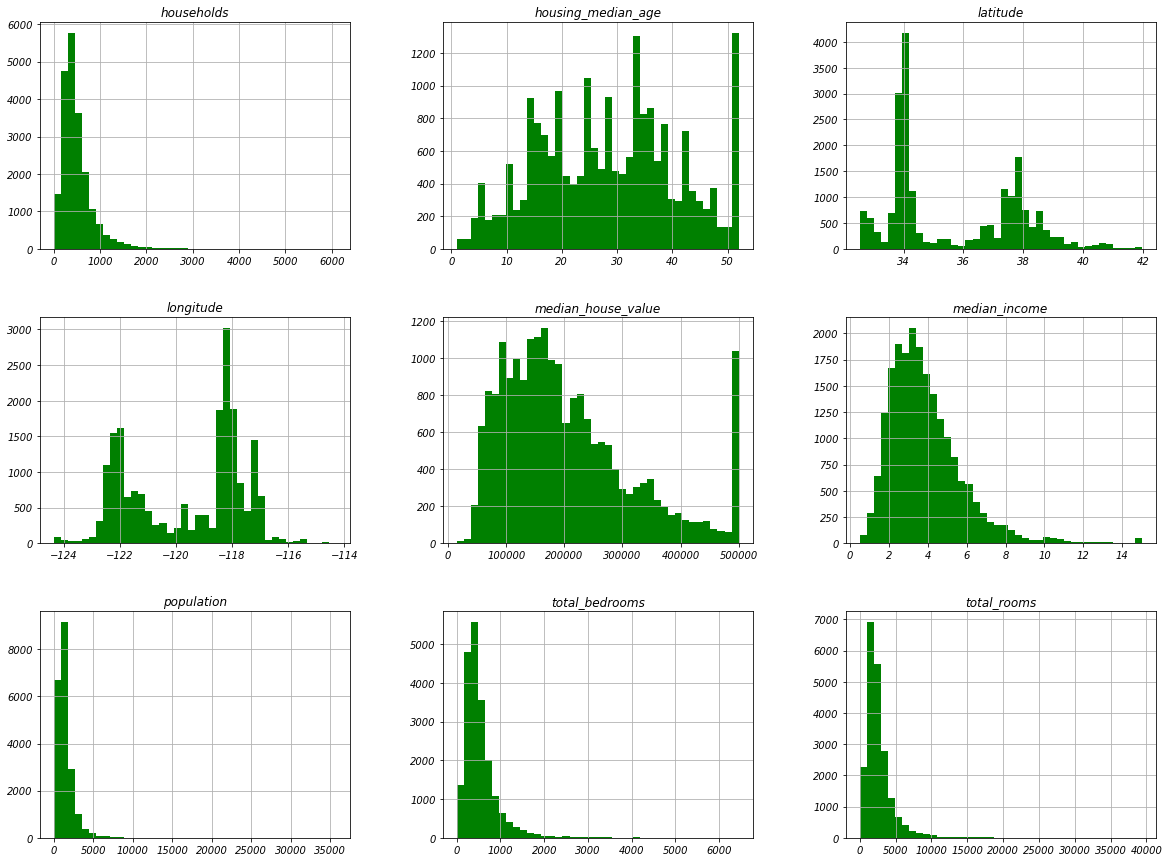

In [8]:
housing_df.hist( bins = 40, color = 'green', figsize = (20,15))

# Assign a test set

In [9]:
def split_train_test(data, test_ratio):
    shuffled_ind = np.random.permutation(len(data))
    test_size = int(len(data) * test_ratio)
    test_ind = shuffled_ind[:test_size]
    train_ind = shuffled_ind[test_size:]
    return data.iloc[train_ind], data.iloc[test_ind]

train_set, test_set = split_train_test(housing_df, 0.2)

print(len(train_set))
print(len(test_set))

16512
4128


# Controlling for changes to the dataset 

We write a function to ensure that all the test data remains as test data

In [10]:
from zlib import crc32

def test_set_check(ids, test_ratio):
    return crc32(np.int64(ids)) & 0xffffffff < test_ratio * 2 **32

def split_train_test_by_id(data, test_ratio, id_col):
    ids = data[id_col]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio)) 
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing_df.reset_index()
train_set, test_set  = split_train_test_by_id(housing_with_id, 0.2, "index")


# Categorise the income category collumn and balance sample within each strata in test + train

In [11]:
housing_with_id['income_cat'] = pd.cut(housing_with_id['median_income'], 
                                      bins = [0., 1.5, 3, 4.5, 6., np.inf], 
                                      labels = [1,2,3,4,5])

housing = housing_with_id

from sklearn.model_selection import StratifiedShuffleSplit

# split the data by cats above
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 1234)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
# then drop the added label 
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis = 1, inplace = True)

# EDA 

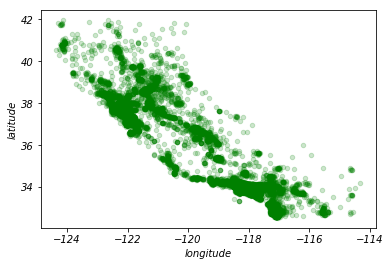

In [12]:
housing = strat_train_set.copy()
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', color = 'green', alpha = 0.2)

The plot above gives us an indication of the densly populated areas. The plot below shows the cost (median) of the houses

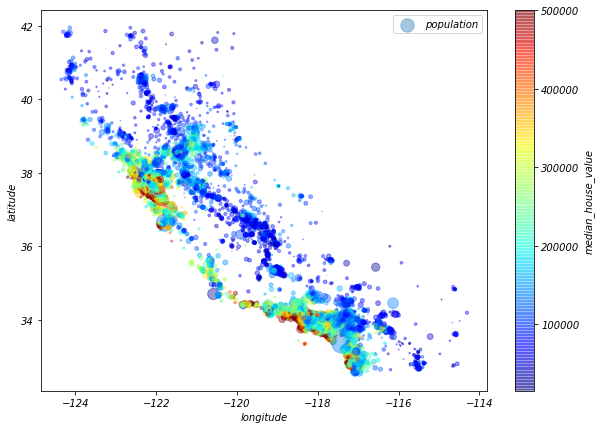

In [13]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

In [14]:
# Are any of the variables correlated? 
m=housing.corr()
m['median_house_value'].sort_values

<bound method Series.sort_values of index                 0.069119
longitude            -0.047697
latitude             -0.144086
housing_median_age    0.099620
total_rooms           0.131453
total_bedrooms        0.048565
population           -0.023790
households            0.064110
median_income         0.690077
median_house_value    1.000000
Name: median_house_value, dtype: float64>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002329B1EB1D0>,
      dtype=object)

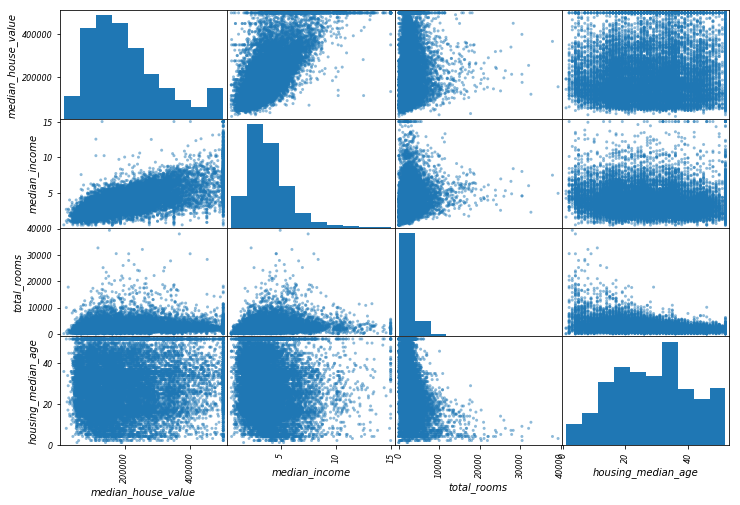

In [15]:
from pandas.plotting import scatter_matrix

va= ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[va], figsize = (12,8))

# Compute additional variables 

In [16]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']


# Prep for algorithms

In [17]:
housing = strat_train_set.drop('median_house_value', axis =1)
housing_labels = strat_train_set['median_house_value'].copy()

# drop missing
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median') 
housing_num = housing.drop('ocean_proximity', axis = 1) # select numeric vars 

In [18]:
imputer.fit(housing_num)
X = imputer.transform(housing_num) # adds the imputed values 
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)

In [19]:
# encode categorical to numeric
from sklearn.preprocessing import OrdinalEncoder
housing_cat = housing[['ocean_proximity']]
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform (housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.]])

In [20]:
# one hot encoder 
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat) # 
housing_cat_1hot # this is a sparse matrix 

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

# Custom transformer 

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin 

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room 
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room] # concatenate
        else:
            return np.c_[X, rooms_per_household, population_per_household] # concatonate 

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


# one hyperparameter (add beds), so we cna use this to easily investigate if this is important later

# Transformation pipeline

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), # first we impute
        ('attribs_adder', CombinedAttributesAdder()), # add the attributes
        ('std_scaler', StandardScaler()), # scale
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [23]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

# Modelling 

In [24]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels) # 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [25]:
# define the lbels and models 
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

# now let's inspect the labels 
print('Preds:', lin_reg.predict(some_data_prepared))
print('Labs:', list(some_labels))

Preds: [280574.07883502  90554.90437334 292102.67769009 227425.43447141
  91821.77973481]
Labs: [228900.0, 76200.0, 218300.0, 117000.0, 225000.0]


In [29]:
# now check the mse
from sklearn.metrics import mean_squared_error 
housing_predictions = lin_reg.predict(housing_prepared)
rmse =  np.sqrt(mean_squared_error(housing_labels, housing_predictions))
print('rmse:', rmse)

rmse: 67679.9629909266


# DT regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
